# Section 7

**Yueying Sun and Johannes Ruf**

January 2024

In this notebook, we use Flow of Funds data to test our mandate model. We download all quarterly data (Z.1 Statistical Release) from Federal Reserve (link: https://www.federalreserve.gov/datadownload/Choose.aspx?rel=z1) and access the data we need by the series number.

## Preparation

First, we import all modules that we need and initialize the datapath, where we put the data downloaded from FoF. In particular, we use 'xml.etree.ElementTree' to get access to the data in xml file and we use the function 'minimize' from the modules 'scipy.optimize' to estimate the optimal parameter.

In [7]:
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn
seaborn.set()

from scipy.optimize import minimize

datapath = './FRB_z1/'

We now choose to access the data through their series number. 

To test our mandate model, we assume that the bond value is the sum of US treasury and the corporate bond, and the equity value is the corporate equity.

Series identifiers:

### Table L210 US Treasury

All sectors; Treasury securities; asset: FL893061105.Q

Rest of the world; Treasury securities; asset: LM263061105.Q

### Table L213 Corporate & Foreign Bonds

All sectors; corporate and foreign bonds; asset: FL893063005.Q

Rest of the world; corporate bonds; asset: LM263063005.Q

### Table L223 Corporate Equities
All sectors; corporate equities; asset: LM893064105.Q

Rest of the world; U.S. corporate equities; asset: LM263064105.Q

In [8]:
SERIES_NAME_LIST = ['FL893061105.Q', 'LM263061105.Q', 'FL893063005.Q', 'LM263063005.Q', 'LM893064105.Q', 'LM263064105.Q']

In [9]:
tree = ET.parse(datapath + 'Z1_data.xml') 
root = tree.getroot()

In [10]:
namespace = {
    'kf': 'http://www.federalreserve.gov/structure/compact/Z1_Z1',
    'frb': 'http://www.federalreserve.gov/structure/compact/common'
}

data_lists = []
time_lists = []

for name in SERIES_NAME_LIST:
    new_list_data = []
    new_list_time = []
    for series in root.findall('.//kf:Series', namespaces=namespace):
        series_name = series.get('SERIES_NAME')
        if series_name == name:
            observations = series.findall('.//frb:Obs', namespaces=namespace)
            
            # Extract OBS_VALUE and TIME_PERIOD and store them in arrays
            for obs in observations:
                obs_value = obs.get('OBS_VALUE')
                time_period = obs.get('TIME_PERIOD')
                new_list_data.append(obs_value)
                new_list_time.append(time_period)
    data_lists.append(new_list_data)
    time_lists.append(new_list_time)

In [11]:
# Checking that all the time lists are the same"
all_identical = True
for list_cand in time_lists:
    all_identical &= (list_cand == time_lists[0])
    
assert all_identical

In [12]:
df = pd.DataFrame(map(list, zip(*data_lists)), index=pd.to_datetime(time_lists[0])).apply(pd.to_numeric)
df.columns = ['UST_All', 'UST_RoW', 'CB_All', 'CB_RoW', 'CE_All', 'CE_RoW']
df = df.mask(df < 0).ffill()    #as before 1960, there are only annual data and others are coded as negative numbers

In [13]:
df['UST'] = df['UST_All'] - df['UST_RoW']
df['CB'] = df['CB_All'] - df['CB_RoW']

df['equity'] = df['CE_All'] - df['CE_RoW']
df['bond'] = df['UST'] + df['CB']

In [14]:
df =  df[['bond', 'equity']].div(1_000_000).copy()    # to turn millions into trillions

# some preparatory computations

df['ratio'] = df['equity']/(df['equity'] + df['bond'])
df['bond_ret'] = df['bond']/df['bond'].shift(1)
df['equity_ret'] = df['equity']/df['equity'].shift(1)

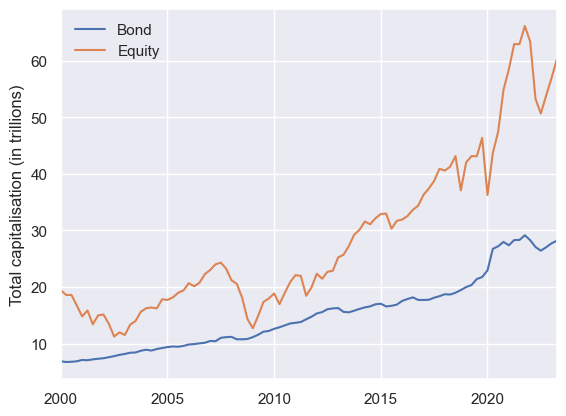

In [15]:
df[['bond', 'equity']].loc['2000':].plot();
plt.legend(['Bond', 'Equity'], frameon=False)
plt.ylabel('Total capitalisation (in trillions)');
plt.savefig('plots/bondequity.png');

We can also plot the empirical mandate.

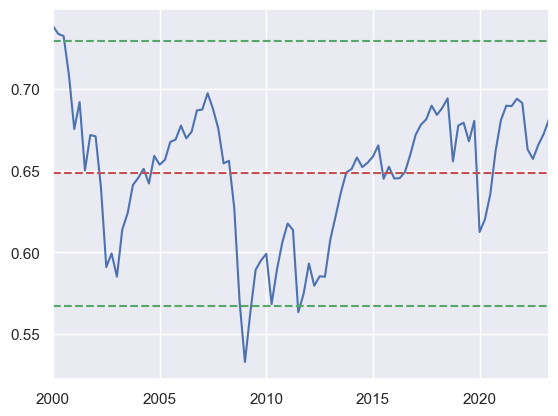

In [16]:
df['ratio'].loc['2000':].plot();
plt.axhline(df['ratio'].loc['2000':].mean(), color='r', ls='--');
plt.axhline(df['ratio'].loc['2000':].mean() - 1.96 * df['ratio'].loc['2000':].std(), color='g', ls='--');
plt.axhline(df['ratio'].loc['2000':].mean() + 1.96 * df['ratio'].loc['2000':].std(), color='g', ls='--');
plt.savefig('plots/empiricalmandate.png');

In [17]:
df['ratio'].loc['2000':].mean()

0.6484595459506607

## Backtesting

### Mandate model

Fix $t \in \mathbb{N}$. Suppose the mandate-implied return function $f_t: (0, \infty) \rightarrow (0,\infty)$ satisfies

$$f_t = \mathrm{id} ^{\alpha^+}$$

where $\alpha^+ = \max(\alpha, 0)$. 

Let $i$ denote the $i$th sample $(i = 1,...., n)$, $y_i$ denote the stock price return (actually return + 1) and $x_i$ denote the bond price return (actually return + 1). Our **GOAL** is to find the **$\alpha$** to minimise our loss function

$$L(\alpha) = \sum_{i=1}^{n}(y_i - f_t(x_i))^2.$$

We use the 'minimize' function of the module 'scipy.optimize' to obtain the optimal parameter $\alpha^*$. We first define the loss function in the cell below, which later is used in the 'minimize' function.

In [23]:
def loss_function1(α, x, y_target):
    y_predicted = x ** α
    return sum((y_predicted - y_target)**2)

Now we approximate the optimal parameter $\alpha^*$. We use different rolling window length $l = 2, 3, 8$ years. This means in the notation above, we have $n = 4l$ (as we have quarterly data) and for every $n$ data, we compute one $\alpha$. We use the 'minimize' function from the 'scipy.optimize' module to find the optimal $\alpha^*$.

In [24]:
nlengths = [8, 12, 16]
colors = ['#ff7f0e','#2ca02c','#9467bd'] #orange, green, purple

In [25]:
columns_alpha = ['alpha_' + str(n) for n in nlengths]
columns_alpha_forecast = ['alpha_forecast_' + str(n) for n in nlengths]
columns_alpha_error = ['alpha_error_' + str(n) for n in nlengths]

plot_labels = (['$l = ' + str(int(n/4)) + '$' for n in nlengths] if all([(n/4).is_integer() for n in nlengths]) 
               else ['$l = ' + str(n/4) + '$' for n in nlengths])

for a in columns_alpha:
    df[a] = np.nan

In [26]:
for (n, a) in zip(nlengths, columns_alpha):
    for i in range(len(df) - n + 1):
        x = df.iloc[i:i+n]['bond_ret']
        y = df.iloc[i:i+n]['equity_ret']
        result = minimize(loss_function1, 1, args=(x, y)) #choose initial value as 1
        df[a].iloc[n - 1 + i] = np.maximum(result.x, 0)

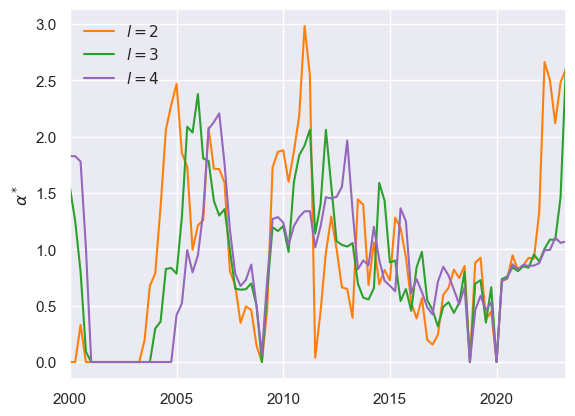

In [27]:
df[columns_alpha].loc['2000':].plot(color=colors)
plt.ylabel('$\\alpha^*$')
plt.legend(plot_labels, frameon=False);#as the data is seasonal
plt.savefig('plots/estimate3_in1.png',bbox_inches='tight');

Under different window lengths, we plot the model-implied stock value and the model prediction error. The model prediction error equals the difference between the equity value observation and the model-implied equity value.

In [28]:
for (f, a) in zip(columns_alpha_forecast, columns_alpha):
    df[f] = df['equity'].shift(1) * (df['bond_ret'] ** df[a].shift(1))

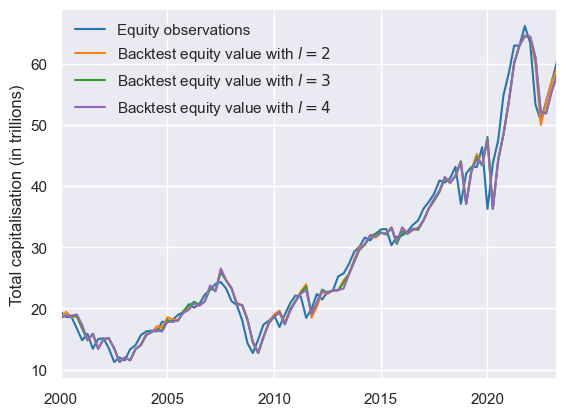

In [29]:
df[['equity'] + columns_alpha_forecast].loc['2000':].plot(color=['#1f77b4'] + colors)
plt.legend(['Equity observations'] + ['Backtest equity value with ' + p for p in plot_labels], frameon=False);
plt.ylabel('Total capitalisation (in trillions)');
plt.savefig('plots/backtest12.png',bbox_inches='tight');

In [30]:
df['error_equity_constant'] = df['equity'] - df['equity'].shift(1)

for (e, f) in zip(columns_alpha_error, columns_alpha_forecast):
    df[e] = df['equity'] - df[f]

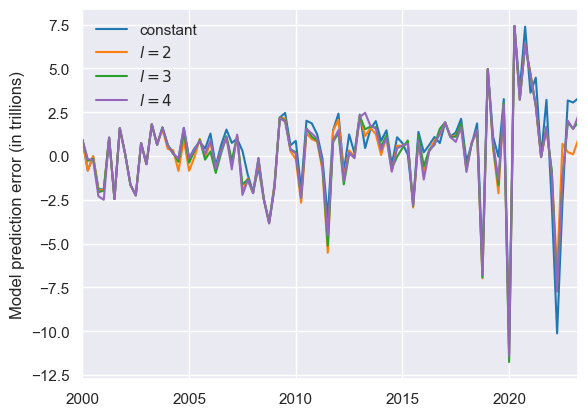

In [31]:
df[['error_equity_constant'] + columns_alpha_error].loc['2000':].plot(color=['#1f77b4'] + colors)

plt.legend(['constant'] + plot_labels, frameon=False)
plt.ylabel('Model prediction error (in trillions)')
plt.savefig('plots/backtesterrorpower.png',bbox_inches='tight');

The backtest above uses the data starting from $2000$. Since the starting date might potentially affect the outcomes of the backtest, we conduct following backtests starting from 1990, 1995, 2000, 2005 and 2010, respectively. 

In [32]:
startyears = ['1990', '1995', '2000', '2005']

In [33]:
df_error = pd.DataFrame()

for t in startyears:
    error_tmp = pd.DataFrame([(df['equity'] - df['equity'].shift(1)).loc[t:].abs().mean()])
    error_tmp = pd.concat([error_tmp, df[columns_alpha_error].loc[t:].abs().mean()])
    df_error = pd.concat([df_error, error_tmp], axis=1)

df_error.index = ['Constant error'] + plot_labels
df_error.columns = pd.MultiIndex.from_product([['Starting year'], startyears])

In [35]:
error_style = (df_error.style.format('{:.2f}')
            .format_index("\\textbf{{{}}}", axis=1)
            .format_index("\\textbf{{\\boldmath{{{}}}}}", axis=0)
              )
print(error_style.to_latex(position="h", hrules=True, multicol_align = "l",
                           caption="Absolute prediction error comparison (in trillions).", 
                           label = "alpha_error_compare", position_float = "centering"))

\begin{table}[h]
\centering
\caption{Absolute prediction error comparison (in trillions).}
\label{alpha_error_compare}
\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{4}{l}{\textbf{Starting year}} \\
 & \textbf{1990} & \textbf{1995} & \textbf{2000} & \textbf{2005} \\
\midrule
\textbf{\boldmath{Constant error}} & 1.45 & 1.67 & 1.83 & 2.03 \\
\textbf{\boldmath{$l = 2$}} & 1.31 & 1.51 & 1.65 & 1.80 \\
\textbf{\boldmath{$l = 3$}} & 1.35 & 1.54 & 1.69 & 1.85 \\
\textbf{\boldmath{$l = 4$}} & 1.36 & 1.57 & 1.72 & 1.87 \\
\bottomrule
\end{tabular}
\end{table}



### Reverse model

Now we consider the model reversely (the dual model). Instead of using the bond data as model input, we now use the equity data as the model input. 

In [36]:
columns_alpha_tilde = ['alpha_tilde_' + str(n) for n in nlengths]
columns_alpha_tilde_forecast = ['forecast_alpha_tilde_' + str(n) for n in nlengths]
columns_alpha_tilde_error = ['error_alpha_tilde_' + str(n) for n in nlengths]

for a in columns_alpha_tilde:
    df[a] = np.nan

In [37]:
for (n, a) in zip(nlengths, columns_alpha_tilde):
    for i in range(len(df) - n + 1):
        x = df.iloc[i:i+n]['equity_ret']
        y = df.iloc[i:i+n]['bond_ret']
        result = minimize(loss_function1, 1, args=(x, y)) #choose initial value as 1
        df[a].iloc[n - 1 + i] = np.maximum(result.x, 0)

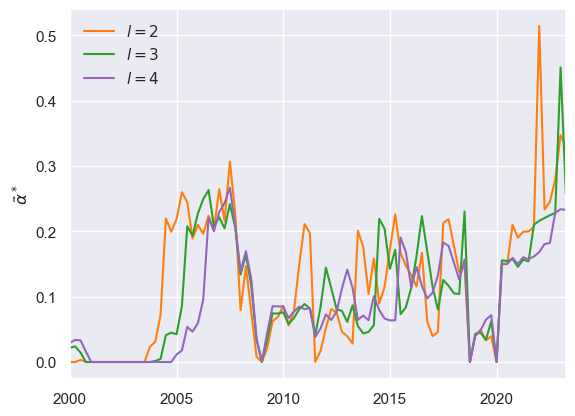

In [38]:
df[columns_alpha_tilde].loc['2000':].plot(color=colors)
plt.ylabel('$\\tilde{\\alpha}^*$')
plt.legend(plot_labels, frameon=False);

In [39]:
for (f, a) in zip(columns_alpha_tilde_forecast, columns_alpha_tilde):
    df[f] = df['bond'].shift(1) * (df['equity_ret'] ** df[a].shift(1))

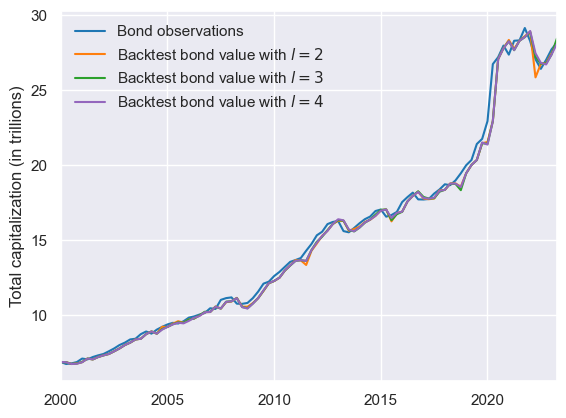

In [42]:
df[['bond'] + columns_alpha_tilde_forecast].loc['2000':].plot(color=['#1f77b4'] + colors)
plt.legend(['Bond observations'] + ['Backtest bond value with ' + p for p in plot_labels], frameon=False);
plt.ylabel('Total capitalization (in trillions)');

In [44]:
df['error_bond_constant'] = df['bond'] - df['bond'].shift(1)

for (e, f) in zip(columns_alpha_tilde_error, columns_alpha_tilde_forecast):
    df[e] = df['bond'] - df[f]

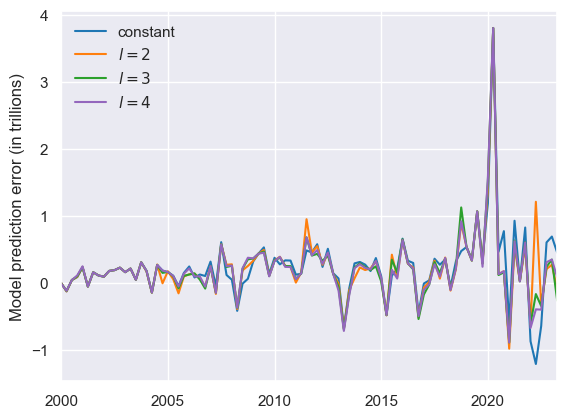

In [45]:
df[['error_bond_constant'] + columns_alpha_tilde_error].loc['2000':].plot(color=['#1f77b4'] + colors)

plt.legend(['constant'] + plot_labels, frameon=False)
plt.ylabel('Model prediction error (in trillions)');

In [47]:
df_error_tilde = pd.DataFrame()

for t in startyears:
    error_tmp = pd.DataFrame([(df['bond'] - df['bond'].shift(1)).loc[t:].abs().mean()])
    error_tmp = pd.concat([error_tmp, df[columns_alpha_tilde_error].loc[t:].abs().mean()])
    df_error_tilde = pd.concat([df_error_tilde, error_tmp], axis=1)

df_error_tilde.index = ['Constant error'] + plot_labels
df_error_tilde.columns = pd.MultiIndex.from_product([['Starting year'], startyears])

df_error_tilde.round(2)

Starting year                  
                        1990  1995  2000  2005
Constant error          0.27  0.30  0.35  0.41
$l = 2$                 0.25  0.28  0.33  0.38
$l = 3$                 0.25  0.28  0.33  0.37
$l = 4$                 0.25  0.28  0.33  0.37